In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Datasets/trash_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os

PATH = 'trash_dataset'

classes = os.listdir(PATH)
classes

['green-glass',
 'brown-glass',
 'cardboard',
 'white-glass',
 'paper',
 'biological',
 'plastic',
 'metal',
 'battery',
 'trash']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: green-glass. Imágenes: 532
Categoría: brown-glass. Imágenes: 923
Categoría: cardboard. Imágenes: 1016
Categoría: white-glass. Imágenes: 620
Categoría: paper. Imágenes: 839
Categoría: biological. Imágenes: 752
Categoría: plastic. Imágenes: 927
Categoría: metal. Imágenes: 943
Categoría: battery. Imágenes: 756
Categoría: trash. Imágenes: 667


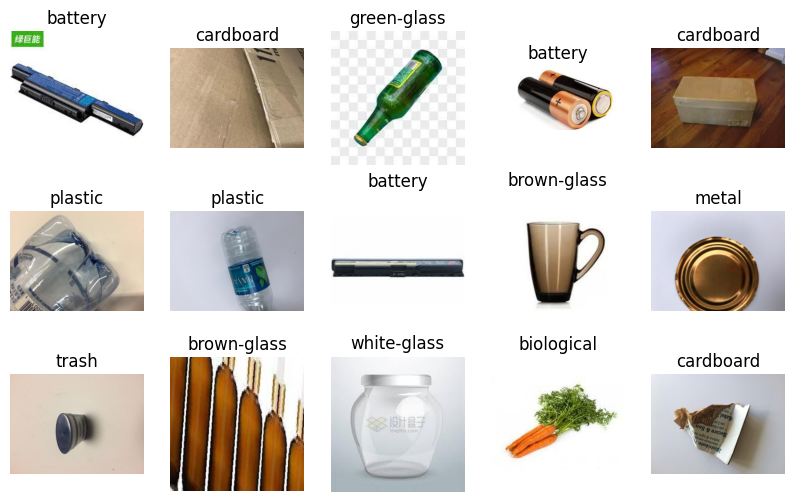

In [ ]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(6380, 1595)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(6380, 1595)

In [ ]:
dataset['train'][2]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

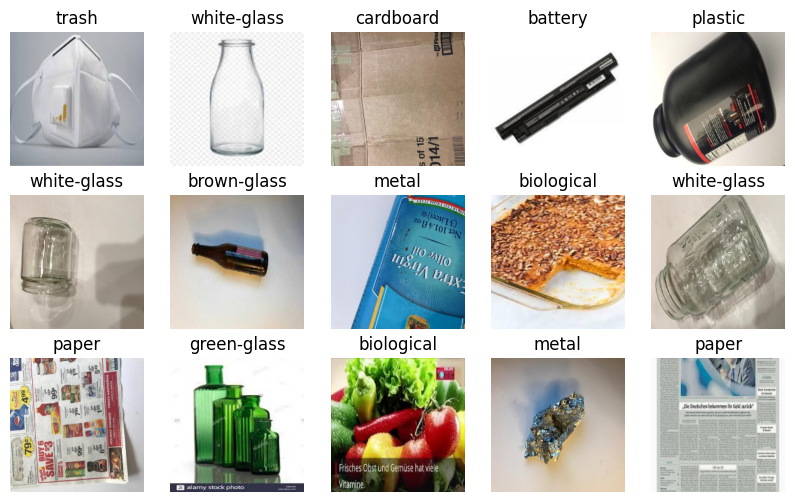

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [ ]:
import torchvision

wide_resnet = torchvision.models.wide_resnet50_2()
wide_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=10, pretrained=False, freeze=False):
    super().__init__()
    # descargamos wide_resnet
    wide_resnet = torchvision.models.wide_resnet50_2(weights=None)
    # nos quedamos con todas las capas menos la última
    self.wide_resnet = torch.nn.Sequential(*list(wide_resnet.children())[:-1])
    if freeze:
      for param in self.wide_resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.wide_resnet(x)
    x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Reducción global del tamaño
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.wide_resnet.parameters():
        param.requires_grad=True

In [ ]:
'''import torch

# Crear una instancia del modelo
model = ModelCustom(n_outputs=10, pretrained=True, freeze=True)  # Ajusta n_outputs según tu tarea y configuración

# Generar una entrada de prueba (64 ejemplos de 3 canales de 224x224)
input_data = torch.randn(64, 3, 64, 64)

# Pasar la entrada a través del modelo
outputs = model(input_data)

# Mostrar la forma de las salidas
print("Forma de las salidas:", outputs.shape)'''


'import torch\n\n# Crear una instancia del modelo\nmodel = ModelCustom(n_outputs=10, pretrained=True, freeze=True)  # Ajusta n_outputs según tu tarea y configuración\n\n# Generar una entrada de prueba (64 ejemplos de 3 canales de 224x224)\ninput_data = torch.randn(64, 3, 64, 64)\n\n# Pasar la entrada a través del modelo\noutputs = model(input_data)\n\n# Mostrar la forma de las salidas\nprint("Forma de las salidas:", outputs.shape)'

In [ ]:
model_custom = ModelCustom(n_outputs=10, pretrained=True, freeze=True)
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 10])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
#Entrenando desde cero
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 3.12017 val_acc 0.12261: 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Epoch 1/15 loss 2.57397 val_loss 3.12017 acc 0.19959 val_acc 0.12261


val_loss 1.65116 val_acc 0.41210: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Epoch 2/15 loss 1.89970 val_loss 1.65116 acc 0.35065 val_acc 0.41210


val_loss 1.83782 val_acc 0.43331: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Epoch 3/15 loss 1.53762 val_loss 1.83782 acc 0.45406 val_acc 0.43331


val_loss 2.52615 val_acc 0.35257: 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Epoch 4/15 loss 1.36941 val_loss 2.52615 acc 0.52747 val_acc 0.35257


val_loss 1.47162 val_acc 0.49080: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Epoch 5/15 loss 1.25925 val_loss 1.47162 acc 0.56771 val_acc 0.49080


val_loss 1.16578 val_acc 0.59795: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 6/15 loss 1.15534 val_loss 1.16578 acc 0.60036 val_acc 0.59795


val_loss 1.55358 val_acc 0.54719: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Epoch 7/15 loss 1.09199 val_loss 1.55358 acc 0.61929 val_acc 0.54719


val_loss 1.56525 val_acc 0.53694: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 8/15 loss 1.04553 val_loss 1.56525 acc 0.63598 val_acc 0.53694


val_loss 1.69299 val_acc 0.44578: 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Epoch 9/15 loss 0.96276 val_loss 1.69299 acc 0.65467 val_acc 0.44578


val_loss 1.07355 val_acc 0.62307: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 10/15 loss 0.95331 val_loss 1.07355 acc 0.66565 val_acc 0.62307


val_loss 1.16388 val_acc 0.61675: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Epoch 11/15 loss 0.87188 val_loss 1.16388 acc 0.69399 val_acc 0.61675


val_loss 1.71636 val_acc 0.49377: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 12/15 loss 0.82485 val_loss 1.71636 acc 0.70786 val_acc 0.49377


val_loss 1.14336 val_acc 0.63556: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 13/15 loss 0.78429 val_loss 1.14336 acc 0.72209 val_acc 0.63556


val_loss 0.94258 val_acc 0.68522: 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Epoch 14/15 loss 0.74462 val_loss 0.94258 acc 0.73977 val_acc 0.68522


val_loss 1.01804 val_acc 0.66325: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]

Epoch 15/15 loss 0.69697 val_loss 1.01804 acc 0.75902 val_acc 0.66325


In [ ]:
#Transfer Learning
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

val_loss 3.18288 val_acc 0.23665: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 1/5 loss 2.85376 val_loss 3.18288 acc 0.16047 val_acc 0.23665


val_loss 2.77176 val_acc 0.20837: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 2/5 loss 2.79381 val_loss 2.77176 acc 0.19595 val_acc 0.20837


val_loss 2.31485 val_acc 0.19610: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 3/5 loss 2.65100 val_loss 2.31485 acc 0.20501 val_acc 0.19610


val_loss 2.51306 val_acc 0.24169: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 4/5 loss 2.60849 val_loss 2.51306 acc 0.23108 val_acc 0.24169


val_loss 2.18113 val_acc 0.31777: 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

Epoch 5/5 loss 2.45050 val_loss 2.18113 acc 0.25391 val_acc 0.31777


In [ ]:
#Fine Tuning
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 7.39297 val_acc 0.09506: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Epoch 1/5 loss 2.47411 val_loss 7.39297 acc 0.20638 val_acc 0.09506


val_loss 2.69165 val_acc 0.28595: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 2/5 loss 1.91047 val_loss 2.69165 acc 0.35686 val_acc 0.28595


val_loss 1.41419 val_acc 0.52837: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 3/5 loss 1.57889 val_loss 1.41419 acc 0.46131 val_acc 0.52837


val_loss 1.84807 val_acc 0.44353: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Epoch 4/5 loss 1.36786 val_loss 1.84807 acc 0.54345 val_acc 0.44353


val_loss 1.54803 val_acc 0.51535: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]

Epoch 5/5 loss 1.26845 val_loss 1.54803 acc 0.57420 val_acc 0.51535


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

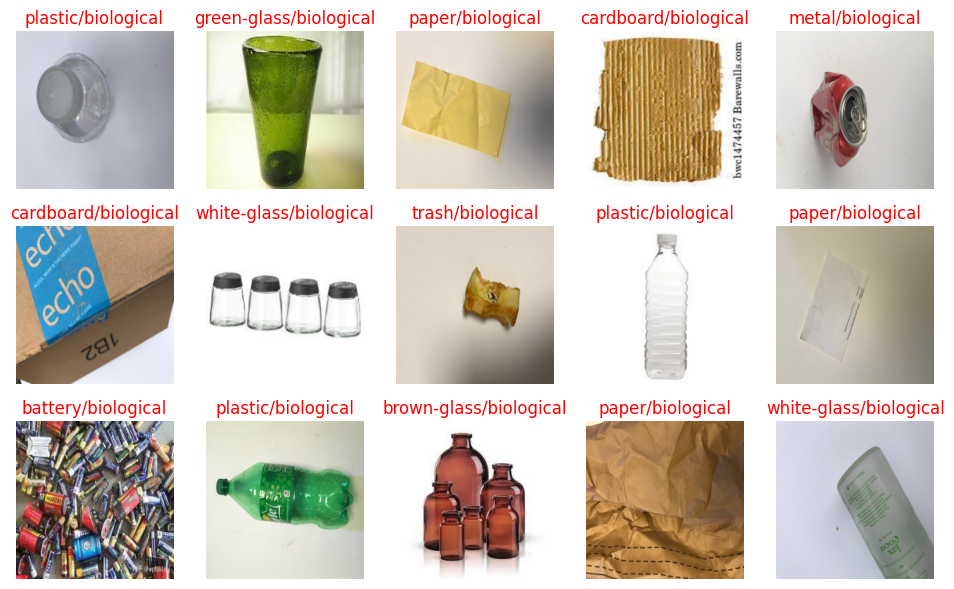

In [ ]:
plot_predictions(model_custom, dataloader, 3, 5)
# Esto mostrará las primeras imágenes del primer lote del DataLoader de prueba:
#3 filas y 5 columnas de subgráficos.